In [ ]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output  # For animation in Colab

In [ ]:
from Fire_Fighter_Env import FireFighterEnv

In [ ]:
# Define the PolicyGradient model
class PolicyGradient(tf.keras.Model):
    def __init__(self, state_size, action_size, use_cnn=False):
        super(PolicyGradient, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.use_cnn = use_cnn
        self.gamma = 0.99  # Higher for better long-term rewards
        self.learning_rate = 0.001
        self.loss_history = []
        self.entropy_beta = 0.01  # Entropy regularization

        self.policy_network = self.build_network()
        self.optimizer = Adam(learning_rate=self.learning_rate, epsilon=1e-7)

    def build_network(self):
        model = Sequential()
        if self.use_cnn:
            model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(self.state_size[0], self.state_size[1], 1)))
            model.add(BatchNormalization())
            model.add(LeakyReLU(alpha=0.01))

            model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(alpha=0.01))

            model.add(Flatten())
        else:
            model.add(Flatten(input_shape=self.state_size))

        model.add(Dense(256, kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.01))

        model.add(Dense(256, kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.01))

        model.add(Dense(self.action_size, activation='softmax'))
        return model

    def get_action(self, state):
        state = np.expand_dims(state, axis=0)
        probs = self.policy_network.predict(state, verbose=0)[0]
        action = np.random.choice(self.action_size, p=probs)
        return action, probs

In [ ]:
# Function to evaluate and visualize the agent's performance
def evaluate_and_visualize(policy, env, num_episodes=30, max_steps=200, animate=True):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()['grid']
        episode_reward = 0
        states_history = [state.copy()]

        for step in range(max_steps):
            action, probs = policy.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = next_state['grid']

            episode_reward += reward
            states_history.append(next_state.copy())

            if animate:
                clear_output(wait=True)
                plt.figure(figsize=(8, 8))
                plt.imshow(next_state, cmap='hot', interpolation='nearest')
                plt.title(f"Episode {episode+1}/{num_episodes} | Step {step+1} | Reward: {episode_reward:.2f}")
                plt.colorbar()
                plt.show()
                plt.pause(0.1)

            state = next_state
            if done:
                break

        total_rewards.append(episode_reward)

    mean_reward = np.mean(total_rewards)
    print(f"\nEvaluation Results: Mean Reward: {mean_reward:.2f}")
    return total_rewards, states_history

In [ ]:
# Training methods for PolicyGradient
def compute_returns(self, rewards):
    returns = []
    discounted_sum = 0
    for r in rewards[::-1]:
        discounted_sum = r + self.gamma * discounted_sum
        returns.insert(0, discounted_sum)
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    return returns

def train(self, states, actions, returns):
    with tf.GradientTape() as tape:
        probs = self.policy_network(states)
        action_masks = tf.one_hot(actions, self.action_size)
        selected_probs = tf.reduce_sum(probs * action_masks, axis=1)
        entropy = -tf.reduce_sum(probs * tf.math.log(probs + 1e-10), axis=1)
        loss = -tf.reduce_mean(tf.math.log(selected_probs + 1e-10) * returns + self.entropy_beta * entropy)

    grads = tape.gradient(loss, self.policy_network.trainable_weights)
    grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]  # Gradient Clipping
    self.optimizer.apply_gradients(zip(grads, self.policy_network.trainable_weights))
    self.loss_history.append(float(loss))
    return float(loss)

# Bind methods to PolicyGradient class
PolicyGradient.compute_returns = compute_returns
PolicyGradient.train = train


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Training function
def train_policy(policy, env, num_episodes=30, max_steps=200):
    rewards_history = []

    for episode in range(num_episodes):
        state = env.reset()['grid']
        states, actions, rewards = [], [], []
        total_reward = 0

        for step in range(max_steps):
            action, _ = policy.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = next_state['grid']

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            total_reward += reward

            state = next_state
            if done:
                break

        states = np.array(states)
        actions = np.array(actions)
        returns = policy.compute_returns(rewards)
        loss = policy.train(states, actions, returns)

        rewards_history.append(total_reward)
        avg_loss = np.mean(policy.loss_history[-len(states):]) if policy.loss_history else 0

        print(f"Training Episode {episode+1}/{num_episodes}")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Avg Loss: {avg_loss:.4f}\n")

    # Plot training rewards after training is complete
    plot_training(rewards_history)
    return rewards_history

# Plotting function
def plot_training(rewards):
    plt.plot(rewards, 'g-', label='Total Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.show()


In [ ]:
# Evaluation and visualization function
def evaluate_and_visualize(policy, env, num_episodes=3, max_steps=200, animate=True):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()['grid']
        episode_reward = 0
        states_history = [state.copy()]

        for step in range(max_steps):
            action, probs = policy.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = next_state['grid']

            episode_reward += reward
            states_history.append(next_state.copy())

            if animate:
                clear_output(wait=True)
                plt.figure(figsize=(8, 8))
                plt.imshow(next_state, cmap='hot', interpolation='nearest')
                plt.title(f"Eval Episode {episode+1}/{num_episodes} | Step {step+1} | Reward: {episode_reward:.2f}")
                plt.colorbar()
                action_names = ['Up', 'Down', 'Left', 'Right']  # Customize this
                plt.text(0, -1, f"Action: {action_names[action]} (Prob: {probs[action]:.2f})")
                plt.show()
                plt.pause(0.1)

            state = next_state
            if done:
                break

        total_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}/{num_episodes}")
        print(f"Total Reward: {episode_reward:.2f}\n")

        if not animate:
            plt.figure(figsize=(8, 8))
            plt.imshow(states_history[-1], cmap='hot', interpolation='nearest')
            plt.title(f"Episode {episode+1} Final State | Total Reward: {episode_reward:.2f}")
            plt.colorbar()
            plt.show()

    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"\nFinal Evaluation Results:")
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"Min Reward: {min(total_rewards):.2f}")
    print(f"Max Reward: {max(total_rewards):.2f}")

    return total_rewards, states_history

In [ ]:
# Functions for saving and loading the model
def save_model(policy, filepath='Best_PG_Model.keras'):
    policy.policy_network.save(filepath)
    print(f"Model saved to {filepath}")

def load_model(policy, filepath='Best_PG_Model.keras'):
    try:
        policy.policy_network = tf.keras.models.load_model(filepath)
        print(f"Loaded model from {filepath}")
        return True
    except:
        print(f"No model found at {filepath}")
        return False

No model found at Best_PG_Model.keras
Starting training

Training Episode 1/50
Total Reward: -1410.00
Avg Loss: -0.0489

Training Episode 2/50
Total Reward: -1580.00
Avg Loss: -0.0193

Training Episode 3/50
Total Reward: -1580.00
Avg Loss: -0.0125

Training Episode 4/50
Total Reward: -1580.00
Avg Loss: -0.0056

Training Episode 5/50
Total Reward: -1390.00
Avg Loss: -0.0044

Training Episode 6/50
Total Reward: -1430.00
Avg Loss: -0.0037

Training Episode 7/50
Total Reward: -1600.00
Avg Loss: -0.0032

Training Episode 8/50
Total Reward: -1560.00
Avg Loss: -0.0028

Training Episode 9/50
Total Reward: -1410.00
Avg Loss: -0.0025

Training Episode 10/50
Total Reward: -1580.00
Avg Loss: -0.0022

Training Episode 11/50
Total Reward: -1600.00
Avg Loss: -0.0020

Training Episode 12/50
Total Reward: -1580.00
Avg Loss: -0.0019

Training Episode 13/50
Total Reward: -1430.00
Avg Loss: -0.0017

Training Episode 14/50
Total Reward: -1600.00
Avg Loss: -0.0016

Training Episode 15/50
Total Reward: -1430

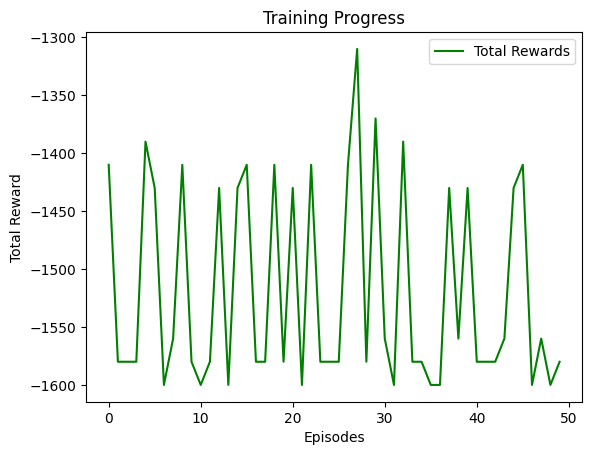

Model saved to Best_PG_Model.keras
Training complete



In [26]:
# Initialize environment and policy, then train or load model
env = FireFighterEnv()
state_size = (env.size[0], env.size[1])
action_size = 4

policy = PolicyGradient(state_size, action_size, use_cnn=True)

if not load_model(policy):
    print("Starting training\n")
    train_policy(policy, env, num_episodes=50, max_steps=200)
    save_model(policy)
    print("Training complete\n")
else:
    print("Model loaded, ready for evaluation\n")